# Implementing HF
There are a great number of public or commercial softwares (see the [Wikipedia page](https://en.wikipedia.org/wiki/List_of_quantum_chemistry_and_solid-state_physics_software)) for quantum chemistry / solid-state physics calculations, including HF methods, FCI methods, or DFT, etc.

# The choise of basis set
The science of basis set design is pretty sophisticated (see the Wikipedia page on [basis set](https://en.wikipedia.org/wiki/Basis_set_(chemistry))). In the early years, there is a basis set called Slater-type-orbits (STO) that try to mimic the behavior of wave function of the electron in the H atom.
$$\chi^{STO}_{nlm}(r)=N\tilde{Y}_{l,m}^{c,s}(\theta,\phi)r^{n-1}\exp(-\zeta r),$$
where $N$ is a normlization constant, and the $l,m$ are angular quantum numbers and the $n$ can be viewd as a principle pseudo-quantum number. The coordinate $x,y,z$ are the relative position of the elctron to a nuclear.
The $\tilde{Y}_{l,m}^{c,s}$ are real-valued shperical harmonics: $\tilde{Y}_{l,m}^{c}\propto P_{l}^{m}(\cos{\theta})\cos{m\phi}$, $\tilde{Y}_{l,m}^{s}\propto P_{l}^{m}(\cos{\theta})\sin{m\phi}$. The parameter $\zeta$ represents a shielded effective nuclear charge. It can be treated as a variational parameter and optimized in molecules or free atoms (it turns out the the optimal $\zeta$ may be greatly different for atoms in molecules and free atoms), and some values are provided in [1].
However, integrals of STO basis functions are hard to compute. Therefore, Gaussian-type-orbits (GTO) are then designed, which support analytic evaluation of integrals:
$$\chi^{GTO}_{lm}(\alpha, r)=N\tilde{Y}_{l,m}^{c,s}(\theta,\phi)r^{l}\exp(-\alpha r^2).$$
The GTO's don't have a nice interpretation as the STO, but it at least has a familar angular part, so we can still refer to s-type GTO's, p-type GTO's, etc. Integrals of different GTO's have heen analytically evaluated by Boys et. al. [2]. To add more chemical picture to the basis set, it is customary to choose linear combiantions of these Gaussians $\sum_i c_i \chi^{GTO}(\alpha_i, r)$ as basis, called the contracted-GTO's (see the Wikipedia page [Gaussian orbital](https://en.wikipedia.org/wiki/Gaussian_orbital) for details). 

One natural choice on contracted GTOs is to fit the STO functions with n different GTOs (with different $\alpha$), leading to the STO-nG basis set with the familiar $n,l,m$ "quantum numbers" [1]. In most applications, STO-nG is a minimal bais set, meaning that only the orbits necessary to hold the electrons are included (e.g., for H, only 1s is used).  The last problem is to choose the exponential parameter ($\zeta$ in the STO's or the corresponding STO-nG's). 

See the Wikipedia page on [basis set](https://en.wikipedia.org/wiki/Basis_set_(chemistry)) for more commonly-used basis. Coefficients of different basis set can be found on [https://www.basissetexchange.org](https://www.basissetexchange.org).


# Reference
[1] W. J. Hehre, R. F. Stewart, and J. A. Pople, Self-Consistent Molecular-Orbital Methods. I. Use of Gaussian Expansions of Slater-Type Atomic Orbitals, The Journal of Chemical Physics 51, 2657 (1969).

[2] Electronic Wave Functions - I. A General Method of Calculation for the Stationary States of Any Molecular System, Proc. R. Soc. Lond. A 200, 542 (1950).

# pySCF
It's tedious to implement all Hartree-Fock methods from scratch, especially handling the basis set. Therefore, I am not going to re-invent my own HF software. Instead, I will just use a nice library [pySCF](https://pyscf.org/index.html) and do some numerical experiment here. However, there is a tricky issue in pySCF because it uses the sym_pos argument for scipy.linalg.solve, which has been removed in scipy 1.11.0. One must either modify the source code pySCF, or use an earlier version of scipy.

In [16]:
from pyscf import gto, scf, fci
import numpy as np
from matplotlib import pyplot as plt

In [32]:
%config InlineBackend.figure_format = "svg"

In [2]:
mol_h2 = gto.Mole()
mol_h2.build(
    atom = '''H 0 0 0; H 0 0 1''',  # unit: angstrom;
    basis = "sto-3g"  # can be a dict for different atoms
)  # a build call is required to convert the geometry format into a standard internal format
print(mol_h2.atom_coords(unit="ANG"))  # either ANG or Bohr
print(mol_h2.ao_labels())

[[0. 0. 0.]
 [0. 0. 1.]]
['0 H 1s    ', '1 H 1s    ']


In [3]:
# evaluating basis set
print(mol_h2.cart)  # spherical GTO's are used by default
coords = np.array([0,0,0]).reshape([1, -1])
ao_value = mol_h2.eval_ao("GTOval_sph", coords)
print(ao_value)

False
[[0.62824688 0.07453264]]


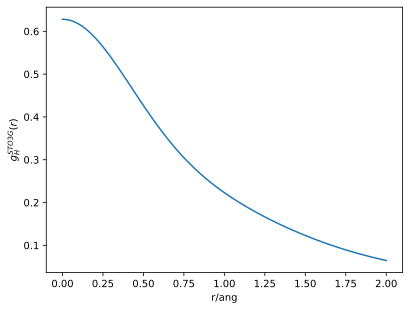

In [29]:
# Plot the STO-3G for H
r_list = np.linspace(0, 2, 100)
coord_list = np.empty([len(r_list), 3])
coord_list[:, 0] = coord_list[:, 1] = 0
coord_list[:, 2] = r_list
# print(coord_list[:5])
h = gto.M(atom=f"H 0 0 0", basis="sto-3g", spin=1)
basis_val = h.eval_ao("GTOval_sph", coord_list)
# print(basis_val.shape)
plt.plot(r_list, basis_val[:, 0])
plt.ylabel(r"$g^{STO3G}_{H}(r)$")
plt.xlabel("r/ang")
plt.show()

In [10]:
rhf_h2 = scf.RHF(mol_h2)
rhf_h2.max_cycle=100
e = rhf_h2.kernel()  # an intermediate binary file will be generated, automatcially deleted if running in a script instead of a notebook
rhf_h2.analyze()
print(e)

converged SCF energy = -1.06610864931794
**** MO energy ****
MO #1   energy= -0.484441680354209 occ= 2
MO #2   energy= 0.457501939047873  occ= 0
 ** Mulliken atomic charges  **
charge of  0H =      0.00000
charge of  1H =      0.00000
Dipole moment(X, Y, Z, Debye):  0.00000,  0.00000,  0.00000
-1.0661086493179366


In [42]:
print(rhf_h2.mo_coeff)
print(rhf_h2.mo_occ)

[[ 0.57802798  0.99650312]
 [ 0.57802798 -0.99650312]]
[2. 0.]


In [18]:
mf = scf.RHF(gto.M(atom="H 0 0 0; H 0 0 1.0", basis="6-31g")).run()  # another way to run RHF, run returns the mf object itself
print(mf.e_tot, mf.mo_occ)
mf.stability()
print()

converged SCF energy = -1.09480796286051
-1.0948079628605116 [2. 0. 0. 0.]
<class 'pyscf.scf.hf.RHF'> wavefunction is stable in the internal stability analysis



In [20]:
# full CI calculation
h2_fci = fci.FCI(mf)  # fci from rhf
e_fci, fci_vector = h2_fci.kernel()
print(e_fci)


-1.1267783526183108


In [30]:
# test of energy unit
e_h_ground = scf.GHF(gto.M(atom="H 0 0 0", basis="6-31g", spin=1)).kernel()
print(e_h_ground)  # Hartree

converged SCF energy = -0.49823291072907  <S^2> = 0.75  2S+1 = 2
-0.49823291072907006


# Simple eg: bond length of H2
We will try to determine the bond length of the hydrodren molecule, and try to appreciate the effect of correlation. We will calculate the total energy of H2 through both RHF and FCI method, at different bond length. The mimima point of total energy is then the bond length of H2.

In [23]:
from pyscf import gto, scf, fci
import numpy as np
# from tqdm import tqdm

In [42]:
# generate H2 structures
h2_list = []
d_list = np.linspace(0.3, 4, 100)
np.save("data/d_list.npy", d_list)
for d in d_list:
    h2 = gto.M(atom=f"H 0 0 0; H 0 0 {d}", basis="6-31g")
    h2_list.append(h2)


In [43]:
e_fci_list = []
e_rhf_list = []
for h2 in h2_list:  # rhf
    rhf_h2 = scf.RHF(h2).run()
    e_rhf_list.append(rhf_h2.e_tot)
    fci_h2 = fci.FCI(rhf_h2)
    e_fci_list.append(fci_h2.kernel()[0])
    # rhf_h2_list.append(rhf_h2)
np.save("data/H2_E_RHF.npy", np.array(e_rhf_list))
np.save("data/H2_E_FCI.npy", np.array(e_fci_list))

converged SCF energy = -0.645154733467444
converged SCF energy = -0.782034064121174
converged SCF energy = -0.881402494973215
converged SCF energy = -0.954206820707094
converged SCF energy = -1.00771925498746
converged SCF energy = -1.04694326419972
converged SCF energy = -1.07542114822688
converged SCF energy = -1.09571807907607
converged SCF energy = -1.10972545300767
converged SCF energy = -1.11885926327513
converged SCF energy = -1.12419412276344
converged SCF energy = -1.12655571278871
converged SCF energy = -1.12658540148576
converged SCF energy = -1.12478592785101
converged SCF energy = -1.12155414725635
converged SCF energy = -1.11720492134054
converged SCF energy = -1.11198891065388
converged SCF energy = -1.10610610637013
converged SCF energy = -1.09971630895329
converged SCF energy = -1.09294734854161
converged SCF energy = -1.0859015814036
converged SCF energy = -1.07866103847315
converged SCF energy = -1.07129150658175
converged SCF energy = -1.06384576286181
converged SCF

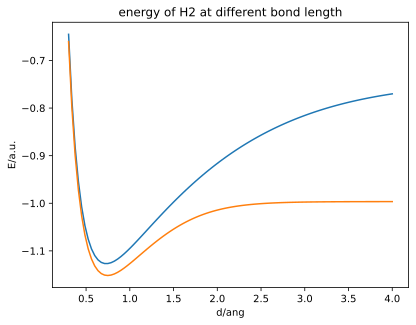

In [47]:
plt.plot(d_list, e_rhf_list)
plt.plot(d_list, e_fci_list)
plt.xlabel("d/ang")
plt.ylabel("E/a.u.")
plt.title("energy of H2 at different bond length")
plt.show()

In the calculation above, we can see that the bond length of H2 is about 0.7 ang. The effect of correlation is strong when the two nuclei are far apart, where the mean-field theory HF fails. In the language of FCI, the coefficient of the ground state HF slater determinant is small, or least doesn't dominate at large bond length. Note that the calculation result is possibly difference if one choose another basis set.

In [50]:
print(f"minimum point of FCI calculation: d = {d_list[np.argmin(e_fci_list)]:.2f} ang.")

minimum point of FCI calculation: d = 0.75 ang.
